In [1]:
import sys
import warnings

warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')
sys.path.append("../")

## Prepare Data

In [2]:
from traditional_models.utils import load_np

X_train, y_train = load_np("train.npy")
X_test, y_test = load_np("test.npy")

In [3]:
from traditional_models.utils import get_sample

datasets = {}
for samples_num in [1000, 5000, 10000, 15000]:
    datasets[samples_num] = get_sample(X_train, y_train, samples_num)

## Random Forest Classifier

In [4]:
from sklearn.ensemble import RandomForestClassifier
from traditional_models.models import search_model_2

params = {  
    "n_estimators": (250, 750),
    "max_depth": (3, 10),
    "min_samples_split": (2, 20),
    "min_samples_leaf": (2, 20),
    "criterion": ["gini", "entropy"]
}

results = search_model_2(datasets, RandomForestClassifier(random_state=200, n_jobs=-1), params, n_iter=10)

In [5]:
from traditional_models.models import report, save_model, get_best

report(results, X_test, y_test)
best_model = get_best(results)[1][0]
save_model(best_model, "RandomForestClassifier")

For ds of size 1000:
	Training score: 0.9054
	Testing score:
		f1_score   - 0.9095
		accuracy_score - 0.9106
For ds of size 5000:
	Training score: 0.9280
	Testing score:
		f1_score   - 0.9283
		accuracy_score - 0.9291
For ds of size 10000:
	Training score: 0.9337
	Testing score:
		f1_score   - 0.9336
		accuracy_score - 0.9342
For ds of size 15000:
	Training score: 0.9359
	Testing score:
		f1_score   - 0.9367
		accuracy_score - 0.9373

Best model for ds_size = 15000
Best params:
{
    "criterion": "entropy",
    "max_depth": 10,
    "min_samples_leaf": 20,
    "min_samples_split": 10,
    "n_estimators": 547
}


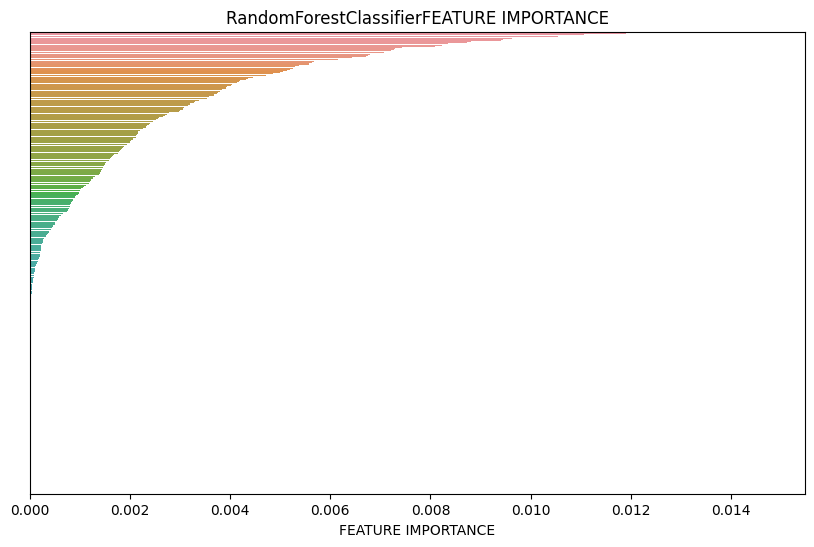

In [6]:
from traditional_models.models import plot_feature_importance

plot_feature_importance(best_model.feature_importances_, "RandomForestClassifier")

Based on above chart let's try to drop reduntant pixels - keep only half most important ones

In [7]:
import numpy as np

importances = best_model.feature_importances_
keep = np.argsort(-importances, )[:int(np.ceil(len(importances) / 2))]

X_reduced, y = datasets[15000]
X_reduced = X_reduced[:, keep]
model_reduced = RandomForestClassifier(**best_model.get_params())
model_reduced.fit(X_reduced, y)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=20,
                       min_samples_split=10, n_estimators=547, n_jobs=-1,
                       random_state=200)

That allowed us to keep nearly the same accuracy and lower training time

In [8]:
from traditional_models.models import print_metrics

print_metrics(model_reduced, X_test[:, keep], y_test)

f1_score   - 0.9374
accuracy_score - 0.9379


## ExtraTreesClassifier

In [9]:
from sklearn.ensemble import ExtraTreesClassifier

# it has nearly the same params as RandomForest
results = search_model_2(datasets, ExtraTreesClassifier(random_state=200, n_jobs=-1), params, n_iter=10)

In [10]:
report(results, X_test, y_test)
best_model = get_best(results)[1][0]
save_model(best_model, "ExtraTreesClassifier")

For ds of size 1000:
	Training score: 0.9131
	Testing score:
		f1_score   - 0.9141
		accuracy_score - 0.9151
For ds of size 5000:
	Training score: 0.9316
	Testing score:
		f1_score   - 0.9327
		accuracy_score - 0.9334
For ds of size 10000:
	Training score: 0.9367
	Testing score:
		f1_score   - 0.9358
		accuracy_score - 0.9364
For ds of size 15000:
	Training score: 0.9378
	Testing score:
		f1_score   - 0.9373
		accuracy_score - 0.9378

Best model for ds_size = 15000
Best params:
{
    "criterion": "entropy",
    "max_depth": 10,
    "min_samples_leaf": 20,
    "min_samples_split": 10,
    "n_estimators": 547
}


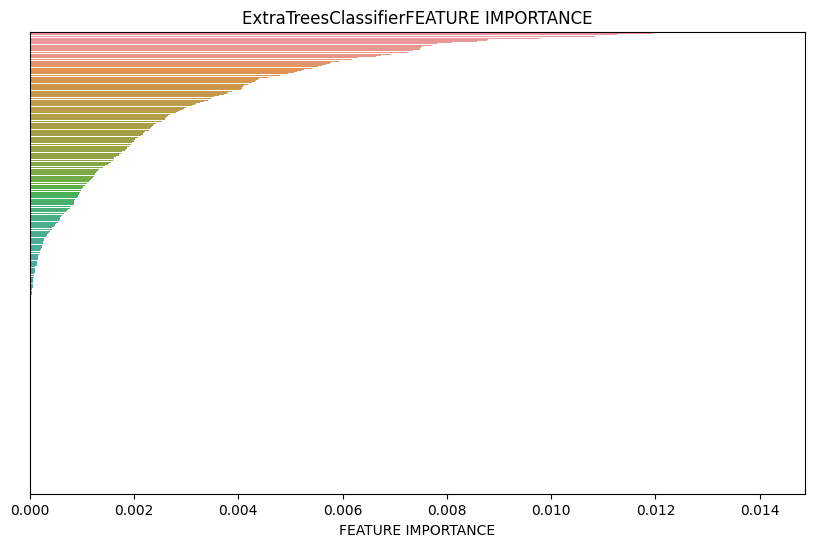

In [11]:
plot_feature_importance(best_model.feature_importances_, "ExtraTreesClassifier")

This time let's try to find the best model using pixels with any feature importance. This time thus to smaller pixel count we allow more estimators

In [12]:
import numpy as np

def get_no_zero_importance(best_model, datasets):
    importances = best_model.feature_importances_
    keep = np.where(importances > 0)[0]
    X_reduced, y = datasets[15000]
    X_reduced = X_reduced[:, keep]
    print(f"Kept {len(keep)} pixels out of {len(best_model.feature_importances_)}.")
    return X_reduced, y, keep

In [13]:
params["n_estimators"] = (250, 1000)

X_reduced, y, keep = get_no_zero_importance(best_model, datasets)
results = search_model_2({15000: (X_reduced, y)}, ExtraTreesClassifier(random_state=200, n_jobs=-1), params, n_iter=10)

Kept 533 pixels out of 723.


In [14]:
report(results, X_test[:, keep], y_test)
best_model = get_best(results)[1][0]
save_model(best_model, "ExtraTreesClassifierLight")

For ds of size 15000:
	Training score: 0.9385
	Testing score:
		f1_score   - 0.9385
		accuracy_score - 0.9390

Best model for ds_size = 15000
Best params:
{
    "criterion": "entropy",
    "max_depth": 10,
    "min_samples_leaf": 20,
    "min_samples_split": 10,
    "n_estimators": 696
}


To later use let's save indexes of these "most important" pixels

In [15]:
import os

os.makedirs(f"data", exist_ok=True)
with open(os.path.join("data", "best_pixels.npy"), "wb") as f:
    np.save(f, keep)

## GradientBoostingClassifier

In [20]:
from sklearn.ensemble import GradientBoostingClassifier

params = {  
    "loss": ["log_loss", "deviance"],
    "max_depth": (3, 10),
    "criterion": ["friedman_mse", "squared_error"],
    "min_samples_split": (2, 20),
    "min_samples_leaf": (2, 20),
    "n_estimators": (250, 1000),
}

results = search_model_2(datasets, GradientBoostingClassifier(random_state=200), params, n_iter=15)

In [ ]:
report(results, X_test[:, keep], y_test)
best_model = get_best(results)[1][0]
save_model(best_model, "GradientBoostingClassifier")

In [ ]:
plot_feature_importance(best_model.feature_importances_, "GradientBoostingClassifier")

In [ ]:
X_reduced, y, keep = get_no_zero_importance(best_model, datasets)
results = search_model_2({15000: (X_reduced, y)}, GradientBoostingClassifier(random_state=200, n_jobs=-1), params, n_iter=15)